### Загрузка и предварительная обработка данных

In [90]:
import pandas as pd


raw_path = "../../data/raw_sales.csv"


df = pd.read_csv(raw_path)


df.head()


,datesold,postcode,price,propertyType,bedrooms
0,2007/2/7 0:00,2607,525000,house,4
1,2007/2/27 0:00,2906,290000,house,3
2,2007/3/7 0:00,2905,328000,house,3
3,2007/3/9 0:00,2905,380000,house,4
4,2007/3/21 0:00,2906,310000,house,3


In [91]:
df.shape


(29580, 5)

In [92]:
df.dtypes


datesold        object
postcode         int64
price            int64
propertyType    object
bedrooms         int64
dtype: object

In [93]:
df.isnull().sum()


datesold        0
postcode        0
price           0
propertyType    0
bedrooms        0
dtype: int64

In [94]:
# 将字符串类型的日期转换为真正的 datetime 类型
# Преобразование строковой даты в тип данных datetime.
df["datesold"] = pd.to_datetime(df["datesold"])

# 按日期从早到晚排序
# Сортировка по дате от самой ранней к самой поздней
df = df.sort_values("datesold")

df.head()


,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07,2607,525000,house,4
1,2007-02-27,2906,290000,house,3
2,2007-03-07,2905,328000,house,3
3,2007-03-09,2905,380000,house,4
4,2007-03-21,2906,310000,house,3


In [95]:
# 只保留两居室的独立房屋（house）
# Будут сохранены только отдельно стоящие дома с двумя спальнями.
df_2b = df[(df["propertyType"] == "house") & (df["bedrooms"] == 2)].copy()

# 查看筛选后的数据规模和前几行
# Отображение размера отфильтрованных данных и первых нескольких строк
df_2b.shape, df_2b.head()


((806, 5),
       datesold  postcode   price propertyType  bedrooms
 45  2007-08-28      2906  325000        house         2
 48  2007-08-30      2905  315000        house         2
 90  2007-11-08      2602  497000        house         2
 92  2007-11-12      2611  465000        house         2
 123 2007-12-14      2602  259000        house         2)

In [96]:
# 将 datesold 设为索引，方便做重采样（时间聚合）
# Установить datesold в качестве индекса
df_2b_ts = df_2b.set_index("datesold")

# 按月重采样，计算每个月的平均价格
# Для расчета средней цены за каждый месяц необходимо ежемесячно проводить повторную выборку.
ts_month = df_2b_ts["price"].resample("ME").mean().to_frame(name="price")

ts_month.head()


,price
datesold,
2007-08-31,320000.0
2007-09-30,NaN
2007-10-31,NaN
2007-11-30,481000.0
2007-12-31,259000.0


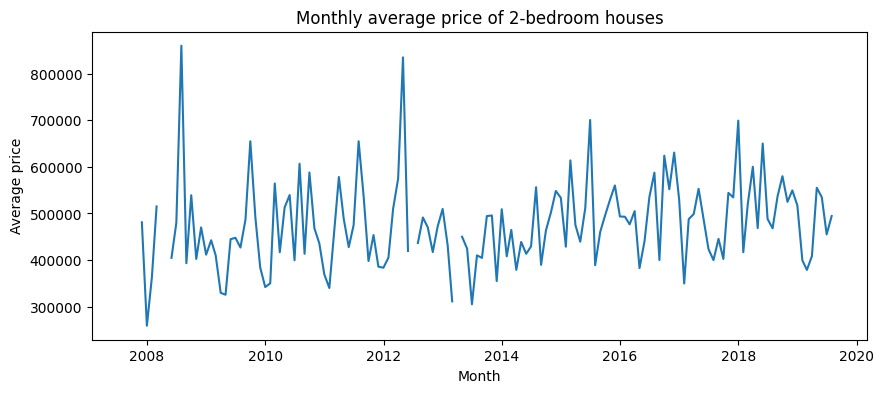

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(ts_month.index, ts_month["price"])
plt.xlabel("Month")
plt.ylabel("Average price")
plt.title("Monthly average price of 2-bedroom houses")
plt.show()


In [98]:

ts_month["price_filled"] = ts_month["price"].ffill()


ts_month.head(10)


,price,price_filled
datesold,,
2007-08-31,320000.000000,320000.000000
2007-09-30,NaN,320000.000000
2007-10-31,NaN,320000.000000
2007-11-30,481000.000000,481000.000000
2007-12-31,259000.000000,259000.000000
2008-01-31,363250.000000,363250.000000
2008-02-29,515000.000000,515000.000000
2008-03-31,NaN,515000.000000
2008-04-30,NaN,515000.000000


### Построение и анализ временного ряда

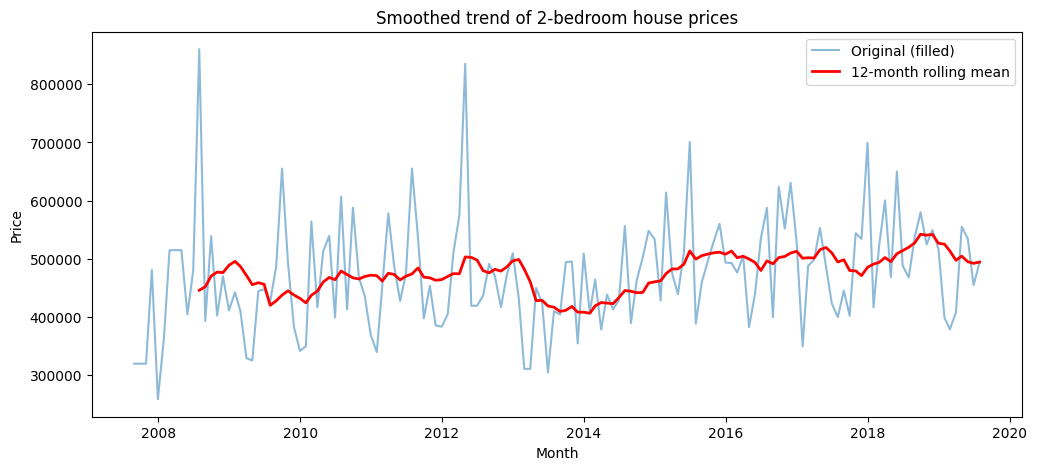

In [99]:
plt.figure(figsize=(12, 5))


plt.plot(ts_month.index, ts_month["price_filled"], 
         label="Original (filled)", alpha=0.5)

# 12个月滚动平均
# Среднее значение за 12 месяцев
plt.plot(ts_month["price_filled"].rolling(12).mean(), 
         label="12-month rolling mean", color="red", linewidth=2)

plt.legend()
plt.title("Smoothed trend of 2-bedroom house prices")
plt.xlabel("Month")
plt.ylabel("Price")
plt.show()


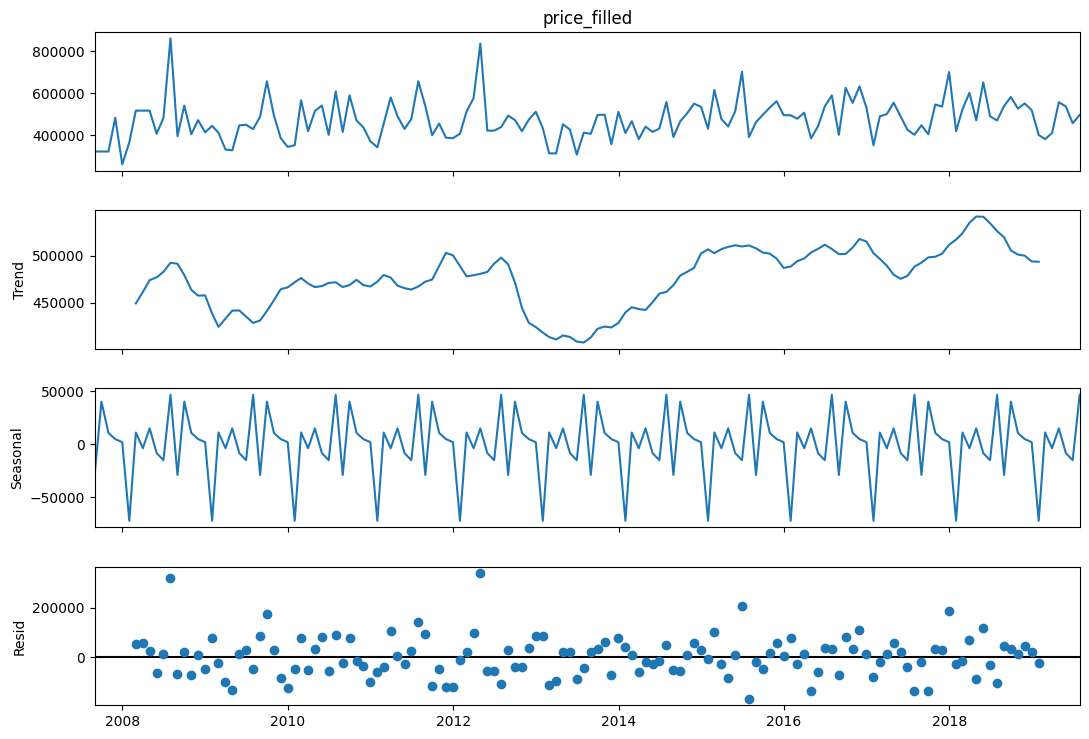

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


result = seasonal_decompose(ts_month["price_filled"], model="additive", period=12)

# 绘制分解图
# Нарисуйте разнесенный вид
fig = result.plot()
fig.set_size_inches(12, 8)
plt.show()


In [101]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title="ADF Test"):
    print(f"=== {title} ===")
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    for value, label in zip(result[:4], labels):
        print(f"{label}: {value}")

    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")

# ① 原始序列检验（price_filled）
# ① Исследование исходной последовательности
adf_test(ts_month["price_filled"], "Original Series (price_filled)")

# ② 一阶差分检验
# ② Тест разности первого порядка
adf_test(ts_month["price_filled"].diff(), "1st Difference Series")


=== Original Series (price_filled) ===
ADF Statistic: -10.14199790026614
p-value: 8.373230536526298e-18
# Lags Used: 0
# Observations Used: 143
Critical Values:
   1%: -3.4769274060112707
   5%: -2.8819726324025625
   10%: -2.577665408088415
=== 1st Difference Series ===
ADF Statistic: -6.495576962018675
p-value: 1.1966613904798733e-08
# Lags Used: 11
# Observations Used: 131
Critical Values:
   1%: -3.481281802271349
   5%: -2.883867891664528
   10%: -2.5786771965503177


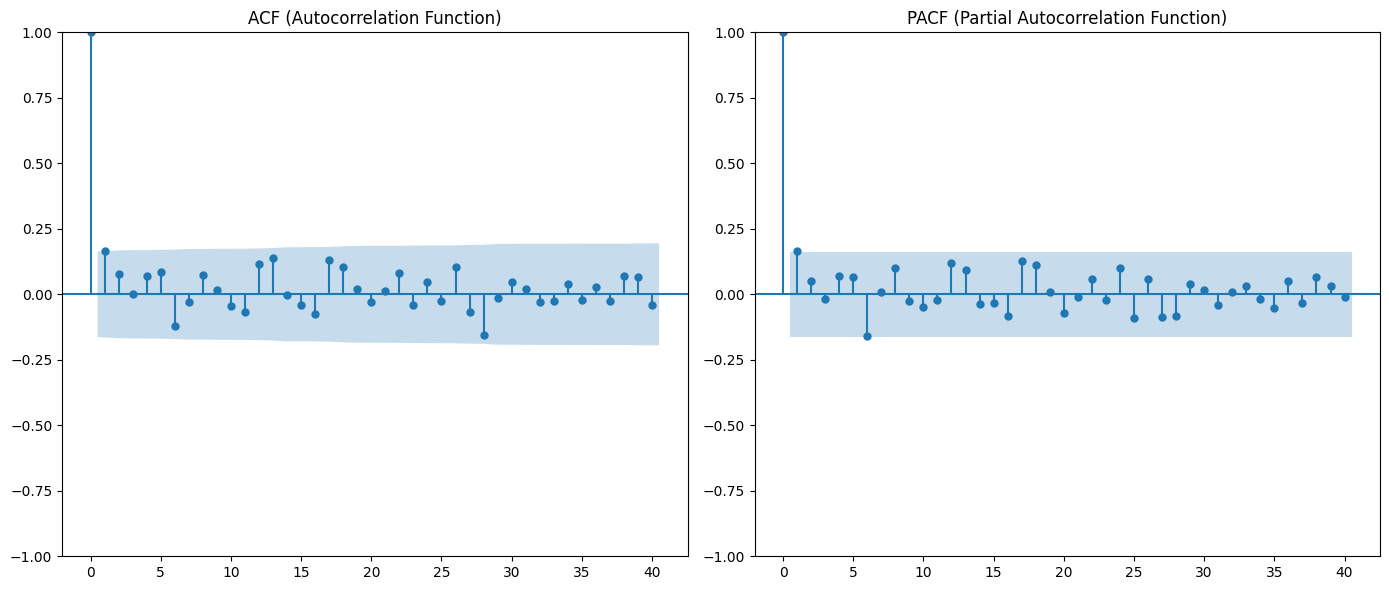

In [102]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

series = ts_month["price_filled"]

# 绘制 ACF 和 PACF
# Нарисуйте ACF и PACF
plt.figure(figsize=(14, 6))

# ACF（自相关函数）
# Автокорреляционная функция 
plt.subplot(1, 2, 1)
plot_acf(series, lags=40, ax=plt.gca())
plt.title("ACF (Autocorrelation Function)")

# PACF（偏自相关函数）
# PACF (Частичная автокорреляционная функция)
plt.subplot(1, 2, 2)
plot_pacf(series, lags=40, ax=plt.gca(), method="ywm")
plt.title("PACF (Partial Autocorrelation Function)")

plt.tight_layout()
plt.show()


### Построение и обучение модели

In [103]:
#模型训练
#Обучение модели
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    ts_month["price_filled"],
    order=(1, 1, 0),
    seasonal_order=(0, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       price_filled   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1726.378
Date:                            Wed, 17 Dec 2025   AIC                           3456.755
Time:                                    20:52:37   BIC                           3462.490
Sample:                                08-31-2007   HQIC                          3459.086
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4890      0.071     -6.921      0.000      -0.627      -0.351
sigma2      2.006e+10    1.9e-13   1.06e+23      0.000    2.01e+10    2.01e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.97   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.16   Prob(JB):                         0.92
Heteroskedasticity (H):               0.60   Skew:                             0.01
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

### Результаты прогнозирования и визуализация

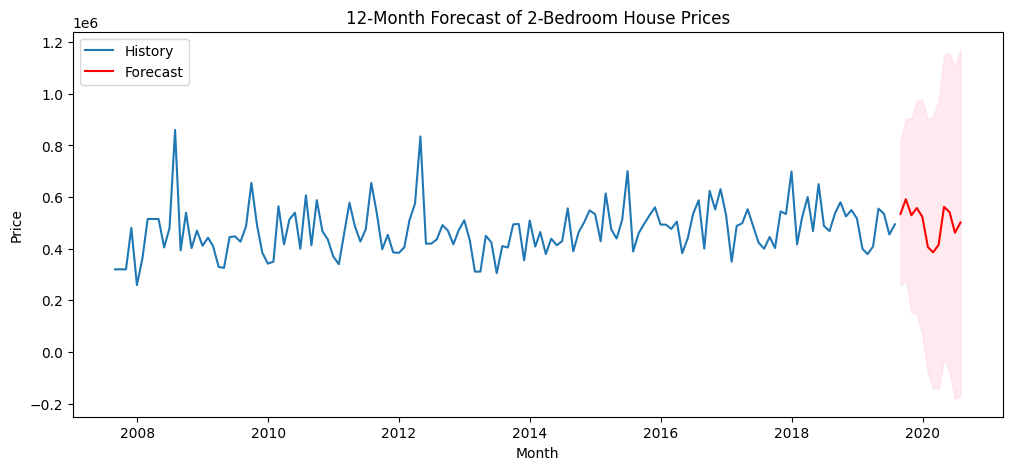

In [104]:
# 预测未来12个月
# Прогнозирование на следующие 12 месяцев
forecast = results.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12,5))
plt.plot(ts_month["price_filled"], label="History")
plt.plot(forecast.predicted_mean, label="Forecast", color="red")

# 上下置信区间
# Верхний и нижний доверительные интервалы
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="pink",
    alpha=0.3
)

plt.title("12-Month Forecast of 2-Bedroom House Prices")
plt.xlabel("Month")
plt.ylabel("Price")
plt.legend()
plt.show()


### Оценка качества модели

In [105]:
import numpy as np

# 1. 取出“模型对历史数据的一步预测”（in-sample prediction）
# 1. Извлечь "одношаговое прогнозирование модели на основе исторических данных"
pred = results.get_prediction()
pred_mean = pred.predicted_mean  
truth = ts_month["price_filled"]  

# 2. 计算 MAE（平均绝对误差）
# 2. Рассчитайте MAE (среднюю абсолютную ошибку).
mae = np.mean(np.abs(pred_mean - truth))

# 3. 计算 RMSE（均方根误差）
# 3. Вычислите RMSE (среднеквадратную ошибку).
rmse = np.sqrt(np.mean((pred_mean - truth) ** 2))

mae, rmse


(np.float64(115849.01147858948), np.float64(150717.02551290864))